# Projet du voyageur de commerce

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import tqdm
from shapely.geometry import LineString, Polygon

## Fonction utilitaire

In [2]:
def show_graph(graph, df):
    rows = []
    for (u, v) in graph.edges:
        p1 = df[df["nom"] == u].geometry.iloc[0]
        p2 = df[df["nom"] == v].geometry.iloc[0]
        row = {'orig': u, 
               'dest': v,
               'geometry': LineString([p1, p2])}
        rows.append(row)
    gdf = gpd.GeoDataFrame(rows, crs="EPSG:4326")
    fig, ax = plt.subplots(figsize=(10, 10)) 
    gdf.plot(ax=ax)
    plt.show()

In [3]:
def graph_from_list(l, G):
    E = nx.Graph()
    nodes = [v1 for (v1, _) in l]
    edges = [ (v1, v2, G[v1][v2]["weight"]) for (v1, v2) in l]
    E.add_nodes_from(nodes)
    E.add_weighted_edges_from(edges)
    return E

In [4]:
def graph_info(G):
    print("longueur du graphe: ", G.size("weight"))
    show_graph(G, villes)

## Initialisation des données

In [5]:
villes = pd.read_csv('./data/villes_france_30000.csv')

In [6]:
villes = villes[villes.population >= 100000]

In [7]:
villes = gpd.GeoDataFrame(villes, geometry=gpd.points_from_xy(villes.longitude, villes.latitude))
villes.set_crs("EPSG:4326").head()

,idx,INSEE,nom,latitude,longitude,population,geometry
0,1,75100,Paris,48.867,2.333,2152423,POINT (2.33300 48.86700)
1,2,13200,Marseille,43.300,5.400,800550,POINT (5.40000 43.30000)
2,3,69380,Lyon,45.750,4.850,415487,POINT (4.85000 45.75000)
3,4,31555,Toulouse,43.600,1.433,358688,POINT (1.43300 43.60000)
4,5,6088,Nice,43.700,7.250,342439,POINT (7.25000 43.70000)


In [8]:
ile_de_france = Polygon([(1.965, 48.62), (1.965, 49.067), (2.899, 49.067), (2.899, 48.62)])
corse = Polygon([(9.65, 43.03), (8, 42.3), (9.26, 41.16)])
villes = villes[(~villes.geometry.within(ile_de_france)) | (villes["nom"] == "Paris")]
villes = villes[(~villes.geometry.within(corse))]

villes.count().nom

34

<AxesSubplot:>

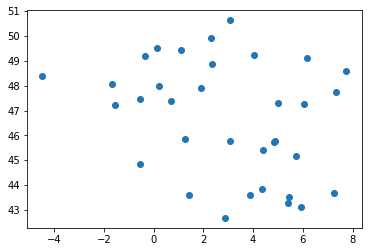

In [9]:
villes.plot()

## Construction de la structure de donnée

In [10]:
n_villes = len(villes)
g = {nom: {} for nom in villes.nom}
#pos = {nom: [] for nom in villes.nom}
#print(pos)
for i in tqdm.tqdm(range(n_villes)):
    dist = villes.iloc[i+1:].distance(villes.iloc[i].geometry)
    #pos[villes.iloc[i]] = [villes.iloc[i].geometry.x, villes.iloc[i].geometry.y]
    for j, d in enumerate(dist):
        g[villes.iloc[i].nom][villes.iloc[i + j + 1].nom] = {"weight": d}
        g[villes.iloc[i + j + 1].nom][villes.iloc[i].nom] = {"weight": d}
        
        

100%|██████████| 34/34 [00:00<00:00, 39.25it/s]


In [11]:
print("distance de Marseille à Lille: ", g["Marseille"]["Lille"]["weight"])
print("distance de Marseille à Paris: ", g["Marseille"]["Paris"]["weight"])

distance de Marseille à Lille:  7.695178880312015
distance de Marseille à Paris:  6.355940371023001


In [12]:
G = nx.from_dict_of_dicts(g)

## Construction de l'arbre de poids minimal

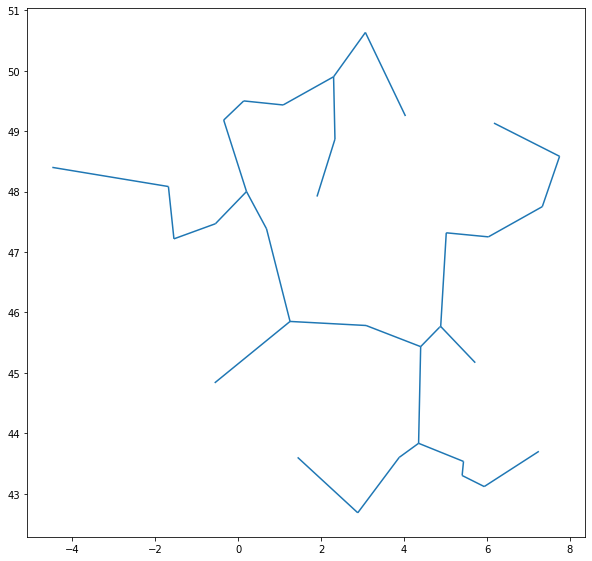

In [13]:
T = nx.minimum_spanning_tree(G)
show_graph(T, villes)

## Completion de cet arbre en graphe eulérien

In [14]:
O = G.subgraph([node for (node, deg) in T.degree() if deg%2 == 1])
print("nombre de sommets de degré impair: ", len(O.nodes))
print(("On est bon", "On est pas bon")[len(O.nodes)%2])
#show_graph(O, villes)

nombre de sommets de degré impair:  14
On est bon


In [15]:
for u, v, d in O.edges(data=True):
    d['weight'] *= -1
MWM = nx.algorithms.max_weight_matching(O, maxcardinality=True)
for u, v, d in O.edges(data=True):
    d['weight'] *= -1

In [16]:
eulerian_ready = nx.multigraph.MultiGraph(T)
weights = [(v1, v2, G[v1][v2]["weight"]) for (v1, v2) in MWM]
eulerian_ready.add_weighted_edges_from(weights)

In [17]:
print(("On est pas bon", "On est bon")[len([deg for (deg, _) in eulerian_ready.degree() ]) == int(villes.count().nom)])

On est bon


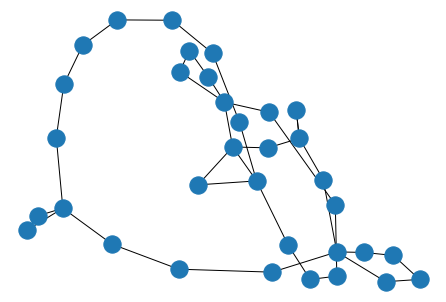

In [18]:
nx.draw(eulerian_ready)

In [19]:
eulerian = list(nx.eulerian_circuit(eulerian_ready))

## Construction du cycle eulérien

In [20]:
E = graph_from_list(eulerian, G)

longueur du graphe:  53.5485928783625


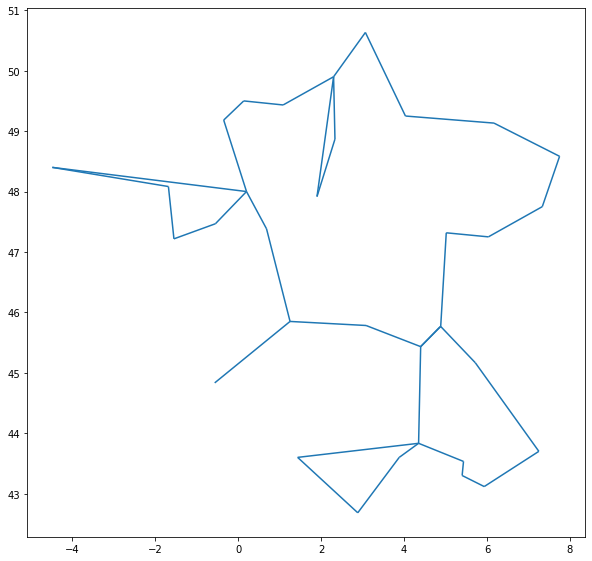

In [21]:
graph_info(E)

## On modifie le cycle pour qu'il soit hamiltonien

In [22]:
eulerian_list = [v1 for (v1, _) in eulerian]
visited = {eulerian_list[0]}
hamiltonian_list = [eulerian_list[0]]
for v in eulerian_list:
    if not v in visited:
        hamiltonian_list.append(v)
        visited.add(v)
#hamiltonian_list.append(eulerian_list[0])

In [23]:
print(len(eulerian_list))
print(len(hamiltonian_list))
print(hamiltonian_list[-1], hamiltonian_list[0])

40
34
Lille Paris


longueur du graphe:  54.02809117826932


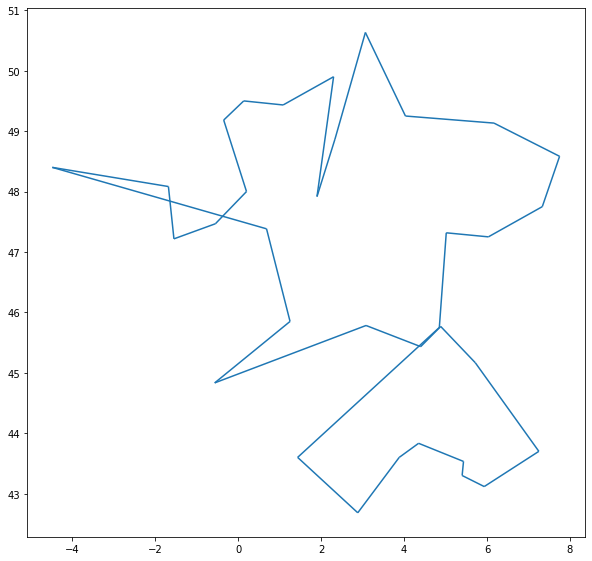

In [24]:
hamiltonian = [(hamiltonian_list[i-1], hamiltonian_list[i]) for i in range(len(hamiltonian_list))]
H = graph_from_list(hamiltonian, G)
graph_info(H)

## On passe un 2-opt sur les sommets qui se croisent